# 4c. Improving the training loop

Now that we are able to compute the loss for our training data, we are able to train the model with the same couple of steps that we have encountered at the end of [**Notebook 2**](../2_Tensors/2b_Tensors_features_Solution.ipynb).

We will take this as a starting point to introduce the `torch.optim` package which provides us with the `Optimizer` API that greatly simplifies the training loop.

## Key concepts of this section

1. `Optimizer` API from the `torch.optim` package

In [1]:
import random
import collections
import math
from typing import Tuple, List

import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

from intro_to_pytorch import data
import helper

## Training loop so far

Going back to the last section of [**Notebook 4b**](4b_loss_functions_Solutions.ipynb), we finished by calculating the per batch loss.

In [27]:
# Nothing new here, just repeating definitions for clarity ... don't do this at home!

class MnistDataSet:
    def __init__(self, train=True):
        subset = "training" if train else "test"
        self.x, self.y = torch.load(data.DATA_PATH / f"MNIST/processed/{subset}.pt")
        self.x = self.x.float()
    
    def __getitem__(self, key) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.x[key], self.y[key]
    
    def __len__(self):
        return len(self.x)
    
class MnistDataLoader:
    def __init__(self, dataset, batch_size, shuffle, transform=None):
        self.dataset, self.batch_size, self.shuffle, self.transform = dataset, batch_size, shuffle, transform
    
    def __iter__(self):
        self.idx = list(range(len(self.dataset)))
        if self.shuffle:
            random.shuffle(self.idx)
        return self
    
    def __next__(self):
        if self.idx:
            batch, self.idx = self.idx[:self.batch_size], self.idx[self.batch_size:]
            x, y = self.dataset[batch]
            if self.transform:
                return self.transform(x, y)
            return x, y
        
        raise StopIteration()

class ImageNormalizer:
    def __init__(self, mean, std):
        self.mean, self.std = mean, std
    
    def __call__(self, x, y):
        return (x - self.mean).div_(self.std), y

class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.reshape(x.shape[0], -1)
        

def get_model():
    return torch.nn.Sequential(collections.OrderedDict([
        ("reshape", torch.nn.Flatten()),
        ("hidden", torch.nn.Linear(28*28,256)),
        ("sigmoid", torch.nn.Sigmoid()),
        ("output", torch.nn.Linear(256,10)),
      ]))

In [3]:
train_dl = MnistDataLoader(MnistDataSet(train=True), 1024, True, ImageNormalizer(33.32, 78.57))
test_dl = MnistDataLoader(MnistDataSet(train=False), 1024, True, ImageNormalizer(33.32, 78.57))
ce = torch.nn.CrossEntropyLoss()

def accuracy(preds, target):
    return (preds.max(-1)[1] == target).float().mean()

# for x, y in train_dl:
#     preds = model(x)
#     print(ce(preds, y))
#     print(accuracy(preds, y))
        

In [**Notebook 2**](../2_Tensors/2b_Tensors_features_Solution.ipynb) we already saw such a loop when finding the parameters for a **linear fit** to some data by minimizing the **MSE**.

Let's us try to reproduce this algorithm with our current setup!

In [4]:
def train_nn(model, n_epochs, lr):
    train_losses = np.array([])
    test_losses = np.array([])
    accuracies = np.array([])

    for epoch in range(n_epochs):
        for x, y in train_dl:
            train_loss = ce(model(x), y)
            train_loss.backward()
            train_losses = np.append(train_losses, train_loss.item())

            with torch.no_grad():
                for p in model.parameters():
                    p += - lr * p.grad
                    p.grad.data.zero_()

        test_loss, acc = evaluate_nn(model, test_dl)
        test_losses = np.append(test_losses, test_loss)
        accuracies = np.append(accuracies, acc)

        print(f"Epoch: {epoch} \t Training loss: {train_losses[-1]} \t Test loss: {test_losses[-1]} \t Test accurarcy: {accuracies[-1]}")
    return train_losses, test_losses, accuracies

def evaluate_nn(model, test_dl):
    preds = torch.tensor([])
    targets = torch.tensor([]).long()
    
    with torch.no_grad():
        for x, y in test_dl:
            targets = torch.cat([targets, y])
            preds = torch.cat([preds, model(x)])
        test_loss = ce(preds, targets)
    return test_loss.item(), accuracy(preds, targets).item()

def plot_metrics(train_losses, test_losses, accuracies):
    fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, figsize=(15,5))
    
    x = np.array(range(len(train_losses)))
    iterations_per_epoch = int(len(train_losses)/ len(test_losses))
    x_val = x[iterations_per_epoch - 1 :: iterations_per_epoch]
    ax0.plot(x, train_losses, label='train')
    ax0.plot(x_val, test_losses, label='test')
   
    ax0.legend()
    ax0.set_ylabel("Loss")
    ax0.set_xlabel("Iteration")
    
    ax1.set_ylabel("Accuracy")
    ax1.plot(x_val, accuracies)
    ax1.set_xlabel("Iteration")
    plt.tight_layout()

Epoch: 0 	 Training loss: 2.158369779586792 	 Test loss: 2.1527888774871826 	 Test accurarcy: 0.5142999887466431
Epoch: 1 	 Training loss: 1.9965535402297974 	 Test loss: 1.995869517326355 	 Test accurarcy: 0.6248999834060669
Epoch: 2 	 Training loss: 1.8434574604034424 	 Test loss: 1.8364449739456177 	 Test accurarcy: 0.7081999778747559
Epoch: 3 	 Training loss: 1.6874278783798218 	 Test loss: 1.6776529550552368 	 Test accurarcy: 0.7282999753952026
Epoch: 4 	 Training loss: 1.514965295791626 	 Test loss: 1.525589108467102 	 Test accurarcy: 0.7565000057220459
Epoch: 5 	 Training loss: 1.3947172164916992 	 Test loss: 1.3865190744400024 	 Test accurarcy: 0.7768999934196472
Epoch: 6 	 Training loss: 1.2802985906600952 	 Test loss: 1.2631876468658447 	 Test accurarcy: 0.79339998960495
Epoch: 7 	 Training loss: 1.162083387374878 	 Test loss: 1.1567317247390747 	 Test accurarcy: 0.8051000237464905
Epoch: 8 	 Training loss: 1.1039177179336548 	 Test loss: 1.065488338470459 	 Test accurarcy: 0

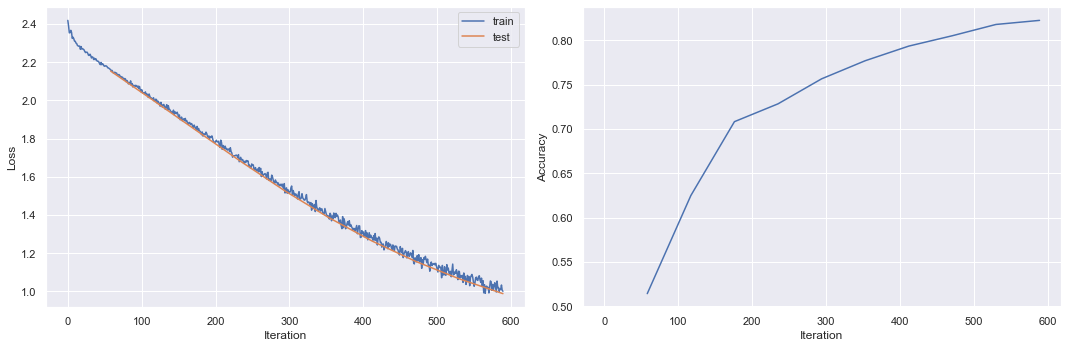

In [5]:
model = get_model()
train_losses, test_losses, accuracies = train_nn(model, n_epochs=10, lr=0.01)
plot_metrics(train_losses, test_losses, accuracies)

## PyTorch Optimizers

The above is a very neat example. The actual training code is only the part from l.6 to l.15, while the rest is mainly for logging.

However, it looks like the part from l.12 to l.15 is very generic and it can certainly be refactored away:

In [6]:
class Optimizer:
    def __init__(self, parameters, lr):
        self.parameters, self.lr = list(parameters), lr
    
    def step(self):
        with torch.no_grad():
            for p in self.parameters:
                p += - self.lr * p.grad
    
    def zero_grad(self):
        with torch.no_grad():
            for p in self.parameters:
                if p.grad is not None:
                    p.grad.data.zero_()
                
                
def train_nn(model, optim, n_epochs):
    train_losses = np.array([])
    test_losses = np.array([])
    accuracies = np.array([])

    for epoch in range(n_epochs):
        for x, y in train_dl:
            
            train_loss = ce(model(x), y)
            train_loss.backward()
            train_losses = np.append(train_losses, train_loss.item())

            optim.step()
            optim.zero_grad()

        test_loss, acc = evaluate_nn(model, test_dl)
        test_losses = np.append(test_losses, test_loss)
        accuracies = np.append(accuracies, acc)
        
        print(f"Epoch: {epoch} \t Training loss: {train_losses[-1]} \t Test loss: {test_losses[-1]} \t Test accurarcy: {accuracies[-1]}")
    return train_losses, test_losses, accuracies

Epoch: 0 	 Training loss: 2.146334409713745 	 Test loss: 2.141728401184082 	 Test accurarcy: 0.5206999778747559
Epoch: 1 	 Training loss: 2.006086587905884 	 Test loss: 1.9842817783355713 	 Test accurarcy: 0.635200023651123
Epoch: 2 	 Training loss: 1.833918571472168 	 Test loss: 1.8244112730026245 	 Test accurarcy: 0.6815000176429749
Epoch: 3 	 Training loss: 1.6845769882202148 	 Test loss: 1.665267825126648 	 Test accurarcy: 0.718500018119812
Epoch: 4 	 Training loss: 1.4990081787109375 	 Test loss: 1.5130517482757568 	 Test accurarcy: 0.7376999855041504
Epoch: 5 	 Training loss: 1.3897515535354614 	 Test loss: 1.3739453554153442 	 Test accurarcy: 0.7605000138282776
Epoch: 6 	 Training loss: 1.2544138431549072 	 Test loss: 1.251354455947876 	 Test accurarcy: 0.7809000015258789
Epoch: 7 	 Training loss: 1.1252002716064453 	 Test loss: 1.1456403732299805 	 Test accurarcy: 0.7936999797821045
Epoch: 8 	 Training loss: 1.0504553318023682 	 Test loss: 1.055617094039917 	 Test accurarcy: 0.

/usr/local/Caskroom/miniconda/base/envs/intro_to_pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/Caskroom/miniconda/base/envs/intro_to_pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/Caskroom/miniconda/base/envs/intro_to_pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/Caskroom/miniconda/base/envs/intro_to_pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Could

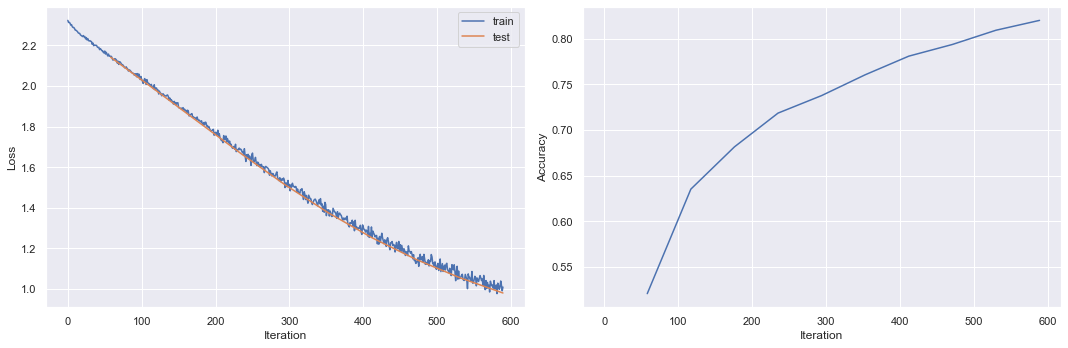

In [28]:
model = get_model()
train_losses, test_losses, accuracies = train_nn(model, Optimizer(model.parameters(), lr=0.01), n_epochs=10)
plot_metrics(train_losses, test_losses, accuracies)

torch.save(model, "../data/model.pt")

This basically introduces the core of what the [torch.optim.Optimizer](https://pytorch.org/docs/stable/_modules/torch/optim/optimizer.html#Optimizer) does. 

The `torch.optim` package, however, does not only offer an almost empty capsule for updating model parameters - it has all the deep learning batteries included: in our simple case, the weight update is performed with the **SGD** rule: 
$$\omega_t = \omega_{t-1} - \lambda * \nabla \omega$$

Much more advanced algorithms exist to perform the weight update, like **SGD with momentum**, **Adagrad**, **Adam**, ...

## Exercise 1:

Check the documentation for a couple of other optimizers and see if you can improve the model performance! 

Epoch: 0 	 Training loss: 0.20431530475616455 	 Test loss: 0.20945456624031067 	 Test accurarcy: 0.9391000270843506
Epoch: 1 	 Training loss: 0.1871768981218338 	 Test loss: 0.14615336060523987 	 Test accurarcy: 0.9585000276565552
Epoch: 2 	 Training loss: 0.11280889064073563 	 Test loss: 0.11967118829488754 	 Test accurarcy: 0.9641000032424927
Epoch: 3 	 Training loss: 0.0986168384552002 	 Test loss: 0.0998125821352005 	 Test accurarcy: 0.9697999954223633
Epoch: 4 	 Training loss: 0.07482827454805374 	 Test loss: 0.0910174548625946 	 Test accurarcy: 0.9722999930381775
Epoch: 5 	 Training loss: 0.05547236278653145 	 Test loss: 0.08517032861709595 	 Test accurarcy: 0.9740999937057495
Epoch: 6 	 Training loss: 0.03318997099995613 	 Test loss: 0.08161068707704544 	 Test accurarcy: 0.9732000231742859
Epoch: 7 	 Training loss: 0.046239349991083145 	 Test loss: 0.075556680560112 	 Test accurarcy: 0.9764000177383423
Epoch: 8 	 Training loss: 0.02226642332971096 	 Test loss: 0.0732382610440254

/usr/local/Caskroom/miniconda/base/envs/intro_to_pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/Caskroom/miniconda/base/envs/intro_to_pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/Caskroom/miniconda/base/envs/intro_to_pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/Caskroom/miniconda/base/envs/intro_to_pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Could

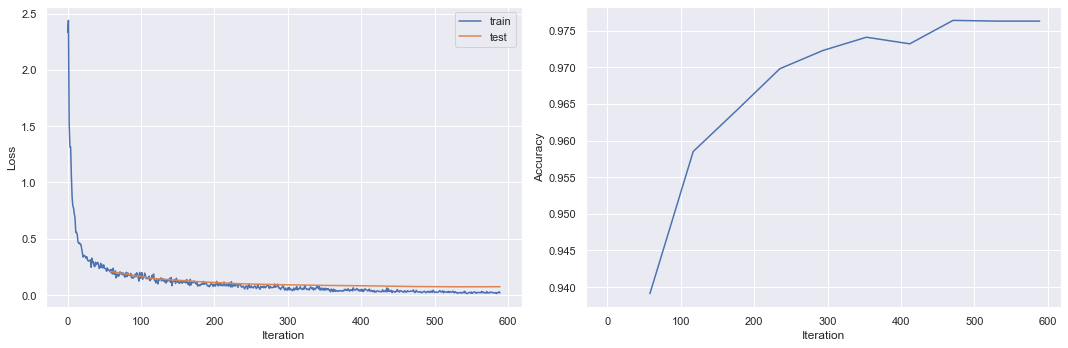

In [29]:
model = get_model()
train_losses, test_losses, accuracies = train_nn(model, torch.optim.AdamW(model.parameters(), lr=0.01), n_epochs=10)
plot_metrics(train_losses, test_losses, accuracies)

torch.save(model, "../data/model_optimized_with_adam.pt")

Epoch: 0 	 Training loss: 0.30099430680274963 	 Test loss: 0.21532247960567474 	 Test accurarcy: 0.9376000165939331
Epoch: 1 	 Training loss: 0.1796049028635025 	 Test loss: 0.14481331408023834 	 Test accurarcy: 0.9560999870300293
Epoch: 2 	 Training loss: 0.13356514275074005 	 Test loss: 0.12037157267332077 	 Test accurarcy: 0.9648000001907349
Epoch: 3 	 Training loss: 0.09878746420145035 	 Test loss: 0.10428772866725922 	 Test accurarcy: 0.9686999917030334
Epoch: 4 	 Training loss: 0.07614321261644363 	 Test loss: 0.09160754084587097 	 Test accurarcy: 0.9728000164031982
Epoch: 5 	 Training loss: 0.04517310857772827 	 Test loss: 0.08575020730495453 	 Test accurarcy: 0.9735999703407288
Epoch: 6 	 Training loss: 0.029509857296943665 	 Test loss: 0.0849730372428894 	 Test accurarcy: 0.9739999771118164
Epoch: 7 	 Training loss: 0.04733061417937279 	 Test loss: 0.07666156440973282 	 Test accurarcy: 0.9751999974250793
Epoch: 8 	 Training loss: 0.023962903767824173 	 Test loss: 0.07569927722

/usr/local/Caskroom/miniconda/base/envs/intro_to_pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/Caskroom/miniconda/base/envs/intro_to_pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/Caskroom/miniconda/base/envs/intro_to_pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/Caskroom/miniconda/base/envs/intro_to_pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Could

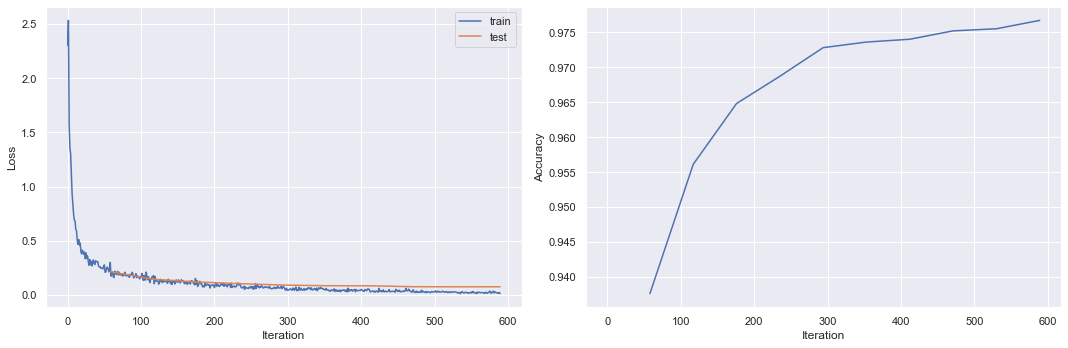

In [30]:
class AdamOptimizer(Optimizer):
    def __init__(self, parameters, lr, beta1 = 0.9, beta2 = 0.999, epsilon=1e-8, wd=1e-2):
        self.parameters, self.lr, self.beta1, self.beta2, self.epsilon, self.wd = list(parameters), lr, beta1, beta2, epsilon, wd
        self.t, self.state = 0, [{"m": 0., "v": 0.} for _ in self.parameters]
    
    def step(self):
        self.t += 1
        with torch.no_grad():
            for s, p in zip(self.state, self.parameters):
                p.mul_(1-self.lr*self.wd)
                s["m"] = self.beta1 * s["m"] + (1-self.beta1)*p.grad
                s["v"] = self.beta2 * s["v"] + (1-self.beta2)*p.grad.pow(2)
                p += - self.lr * math.sqrt(1-self.beta2**self.t) / (1 - self.beta1**self.t) * s["m"] / (s["v"].sqrt() + self.epsilon)
                
model = get_model()
train_losses, test_losses, accuracies = train_nn(model, AdamOptimizer(model.parameters(), lr=0.01), n_epochs=10)
plot_metrics(train_losses, test_losses, accuracies)

torch.save(model, "../data/model_optimized_with_adam.pt")

Epoch: 0 	 Training loss: 0.82867032289505 	 Test loss: 0.7825676798820496 	 Test accurarcy: 0.8490999937057495
Epoch: 1 	 Training loss: 0.3820175528526306 	 Test loss: 0.32469385862350464 	 Test accurarcy: 0.9090999960899353
Epoch: 2 	 Training loss: 0.29249703884124756 	 Test loss: 0.2333122044801712 	 Test accurarcy: 0.930899977684021
Epoch: 3 	 Training loss: 0.19391681253910065 	 Test loss: 0.1847110092639923 	 Test accurarcy: 0.9445000290870667
Epoch: 4 	 Training loss: 0.18653245270252228 	 Test loss: 0.14851227402687073 	 Test accurarcy: 0.9549999833106995
Epoch: 5 	 Training loss: 0.08871901780366898 	 Test loss: 0.12472528964281082 	 Test accurarcy: 0.9610000252723694
Epoch: 6 	 Training loss: 0.10456597805023193 	 Test loss: 0.10537082701921463 	 Test accurarcy: 0.9678999781608582
Epoch: 7 	 Training loss: 0.060336608439683914 	 Test loss: 0.09464988112449646 	 Test accurarcy: 0.9695000052452087
Epoch: 8 	 Training loss: 0.06805800646543503 	 Test loss: 0.08811363577842712 

/usr/local/Caskroom/miniconda/base/envs/intro_to_pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/Caskroom/miniconda/base/envs/intro_to_pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/Caskroom/miniconda/base/envs/intro_to_pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/Caskroom/miniconda/base/envs/intro_to_pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Could

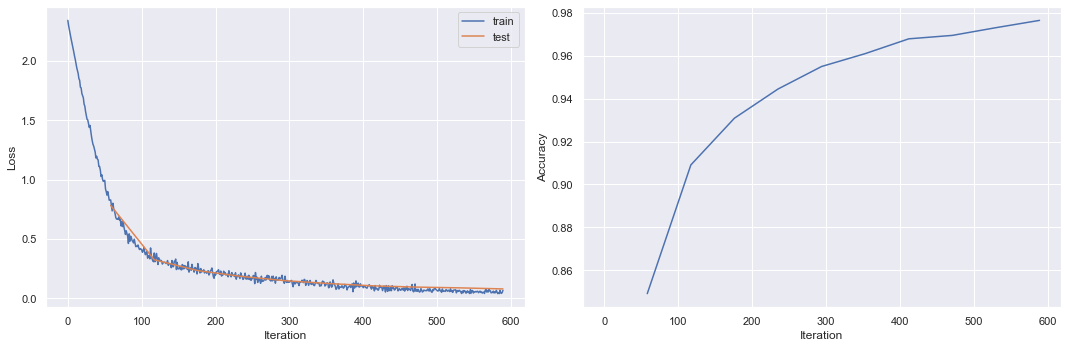

In [31]:
class LambOptimizer(Optimizer):
    def __init__(self, parameters, lr, beta1 = 0.9, beta2 = 0.999, epsilon=1e-8, wd=1e-2):
        self.parameters, self.lr, self.beta1, self.beta2, self.epsilon, self.wd = list(parameters), lr, beta1, beta2, epsilon, wd
        self.t, self.state = 0, [{"m": 0., "v": 0.} for _ in self.parameters]
    
    def step(self):
        self.t += 1
        with torch.no_grad():
            for s, p in zip(self.state, self.parameters):
                s["m"] = self.beta1 * s["m"] + (1-self.beta1)*p.grad
                s["v"] = self.beta2 * s["v"] + (1-self.beta2)*p.grad.pow(2)
                
                r = s["m"] / (s["v"].sqrt() + self.epsilon)* math.sqrt(1-self.beta2**self.t) / (1 - self.beta1**self.t)
                scale = r + self.wd*p
                p += - self.lr * scale * torch.norm(p).clamp(0., 10.) / torch.norm(scale)
                
model = get_model()
train_losses, test_losses, accuracies = train_nn(model, LambOptimizer(model.parameters(), lr=0.01), n_epochs=10)
plot_metrics(train_losses, test_losses, accuracies)

torch.save(model, "../data/model_optimized_with_lamb.pt")

## Exercise 2:

What other API is exposed by the `torch.optim` package?

In [11]:
# TODO: Exercise 2

# Anwser is _LRScheduler

# Excercise 3:

Save only the model's parameters to *../data/model_params.pt*.

In [34]:
torch.save(model.state_dict(), "../data/model_params.pt")

## Section summary

The `torch.optim` package provides useful APIs and state-of-the-art algorithms for performing weight updates and learning rate scheduling.